# Week 3: Principle component analysis, the SVD and low-dimensional projections 
[Jacob Page](jacob-page.com)

In this workshop we will work through a set of problems on dimensionality reduction -- a basic example of unsupervised learning (perhaps a better term here would be "self-supervised"). 

We will work with a dataset of images and attempt to use PCA to identify underlying "patterns" and explore the utility of the associated low-dimensional representations to partition the data into its distinct classes.

---


As you work through the problems it will help to refer to your lecture notes. The exercises here are designed to reinforce the topics covered this week. Please discuss with the tutors if you get stuck, even early on! 


# Imports

We're only going to need a couple of libraries this week. We'll add one or two more as we work through the problems below. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

Our dataset will be the famous "MNIST" dataset of handwritten digits, which we will download from the keras library. The dataset consists of a set of greyscale images of the numbers 0-9 and corresponding labels. Usually the goal is to train a classifier (i.e. given an image, what digit does it correspond to?). Here we will throw away the labels and use the images themselves to explore dimensionality reduction, which is an example of a unsupervised learning problem. 

First, load the data:

In [2]:
from tensorflow.keras.datasets import mnist
(images_all_digits, y_all_digits), _ = mnist.load_data() # we are only loading the training set here [unsupervised!]

11501568/11490434 [==============================] - 0s 0us/step


# Exercise 0
What object is returned by the command above? What shape/datatype etc if an array?  

In [3]:
images_all_digits.shape # explore the raw data X_all_digts -- what shape? What modifications do we need to make it into X in the notes

(60000, 28, 28)

# Exercise 1
Create a dictionary, with the digit classes (0-9) as keys, where the correponding values are the set of all images corresponding to that particular label. 

In [4]:
digits_dict = {}
count = 0

for label in y_all_digits:
  if label in digits_dict:
    digits_dict[label] += [images_all_digits[count]]
  else:
    digits_dict[label] = [images_all_digits[count]]
  count += 1

Verify you have done this correctly by picking a some of labels and plotting a few images from within your dictionary. 

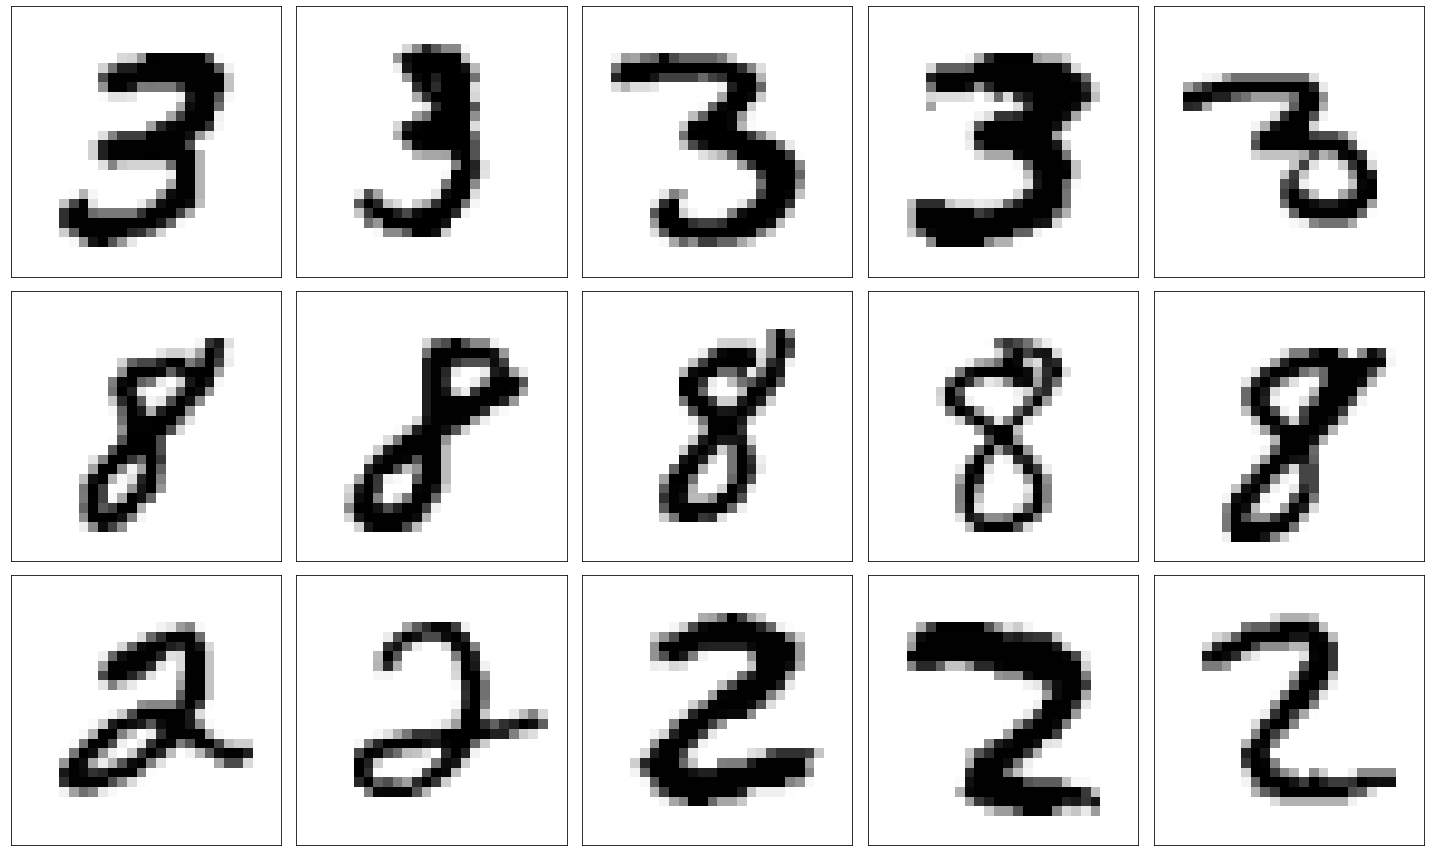

In [5]:
test_labels = [3, 8, 2]
n_images_per_label = 5

fig = plt.figure(figsize=(4*n_images_per_label, 4*len(test_labels)))
for i in range(len(test_labels)):
  for j in range(n_images_per_label):
    ax_number = i * n_images_per_label + 1 + j
    ax = fig.add_subplot(len(test_labels), n_images_per_label, ax_number)
    ax.imshow(digits_dict[test_labels[i]][j], cmap='gray_r')
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

# Exercise 2 
Now focus on the 3s only and create a data matrix $X$ of dimension $N$ (# datapoints) by $D$ (# features).

What are the features in this problem? How many features are there? 

In [6]:
N_threes = len(digits_dict[3])
N_x, N_y = digits_dict[3][0].shape 

X_threes = np.asarray(digits_dict[3]).reshape((N_threes, -1))
X_threes.shape

(6131, 784)

# Exercise 3 
Now compute and plot the "mean" three.

"Standardize" your features by subtracting the mean three and generate a new data matrix $\mathbf X'$. 

Visualise some of the images and compare to the original data. 

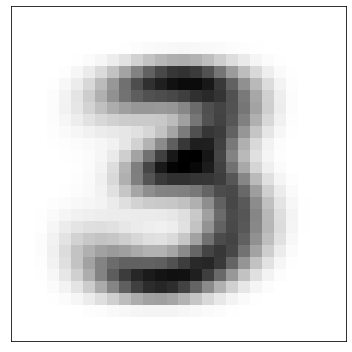

In [7]:
X_three_mean = np.mean(X_threes, axis=0, keepdims=True)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.imshow(X_three_mean.reshape(N_x, N_y), cmap='gray_r')
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()

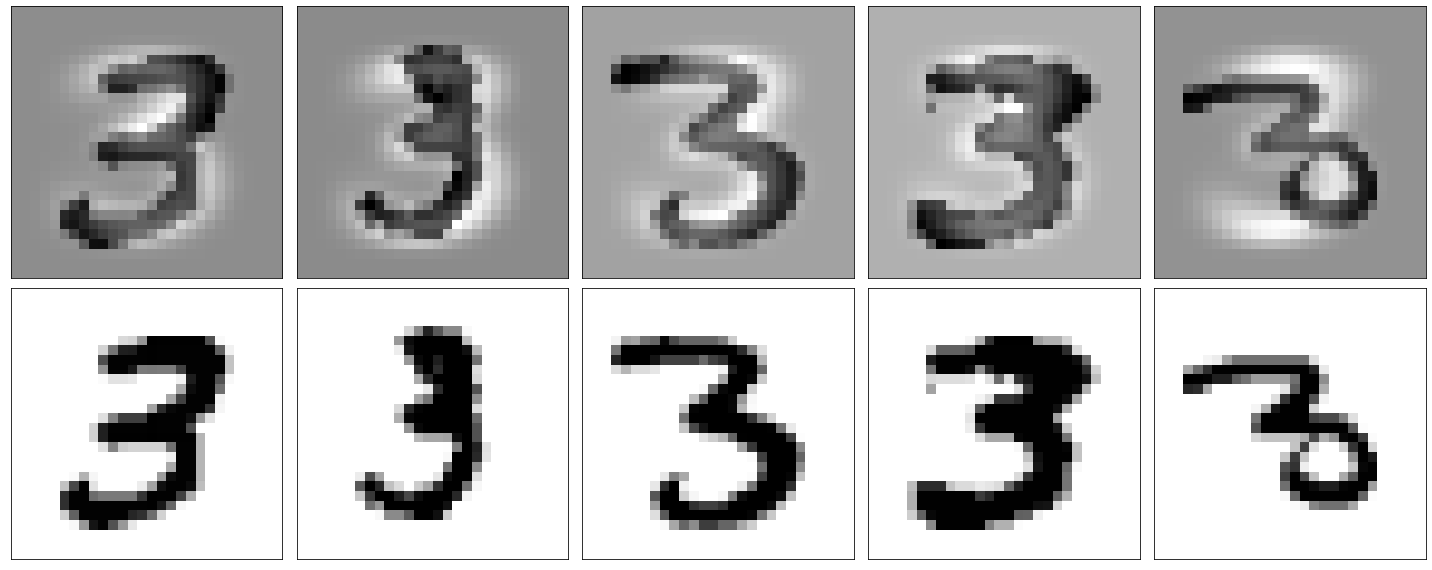

In [8]:
X_three_shifted = X_threes - X_three_mean

n_images = 5

fig = plt.figure(figsize=(4*n_images, 4*2))
for j in range(n_images):
  ax = fig.add_subplot(2, n_images, j+1)
  ax.imshow(X_three_shifted[j,:].reshape((N_x, N_y)), cmap='gray_r')
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(2, n_images, j+1+n_images)
  ax.imshow((X_three_shifted[j,:] + X_three_mean.reshape((-1,))).reshape((N_x, N_y)), cmap='gray_r')
  ax.set_xticks([])
  ax.set_yticks([])
fig.tight_layout()

# Exercise 4
Using an appropriate matrix decomposition of $\mathbf X'$, find a set of basis vectors, $\{\mathbf v_k\}$, the first $q$ of which would produce the optimal rank-$q$ reconstruction of $\mathbf X'$. 

You might like to use a function from within the scipy.linalg package. 

Check the documentation of the function you apply to understand the connection with the methods in the lecture notes. What are the shapes of the matrices you obtain, do they match what you expect? 

Plot the dominant three basis vectors $\mathbf v_{1,2,3}$ as images.  

Verify they are an orthogonal basis. 

In [9]:
import scipy.linalg as la
U, Sigma, V_T = la.svd(X_three_shifted, full_matrices=True) 

print(U.shape, Sigma.shape, V_T.shape)

(6131, 6131) (784,) (784, 784)


Setting full_matrices=False would produce the "economy SVD" where only the first $D$ singular vales and left singular vectors are returned. 

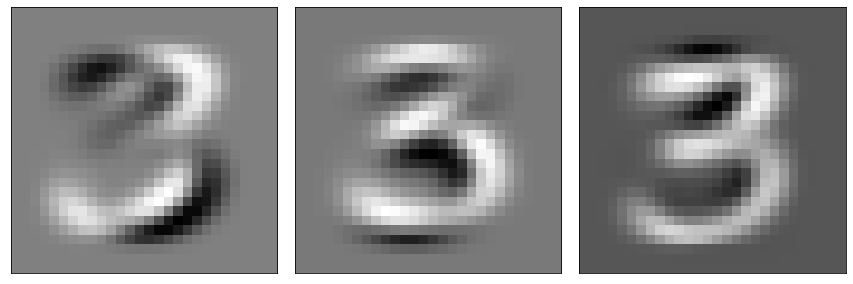

In [10]:
n_plot = 3

fig = plt.figure(figsize=(n_plot*4, 4))
for n in range(n_plot):
  ax = fig.add_subplot(1, n_plot, n+1)
  ax.imshow(V_T[n,:].reshape((N_x, N_y)), cmap='gray_r')
  ax.set_xticks([])
  ax.set_yticks([])
fig.tight_layout()

In [11]:
proj = np.zeros((n_plot, n_plot), dtype='float')
for i in range(n_plot):
  for j in range(n_plot):
    proj[i, j] = V_T[i, :].dot(V_T[j, :])
  
proj

array([[ 1.00000000e+00,  9.67650439e-17, -2.83654393e-16],
       [ 9.67650439e-17,  1.00000000e+00,  3.04877651e-16],
       [-2.83654393e-16,  3.04877651e-16,  1.00000000e+00]])

# Exercise 5
How is the algorithm you applied above related to the covariance matrix of our dataset of 3s? Perform an appropriate matrix decomposition of the covariance matrix and verify the correspondence. 

Note: the numbers involved will likely be very large. Think about a meaningful way to check the agreement and the plots you might want to generate. 

In [12]:
Cov = (X_three_shifted.T).dot(X_three_shifted) # divide by (N-1) for true Cov

eigs, left_v, right_v = la.eig(Cov, left=True)

Eigenvalues of $\mathbf X'^T \mathbf X'$ are equal to the singular values of $\mathbf X'$ squared.

Text(0, 0.5, '$|\\Sigma - \\sqrt{\\lambda}|$')

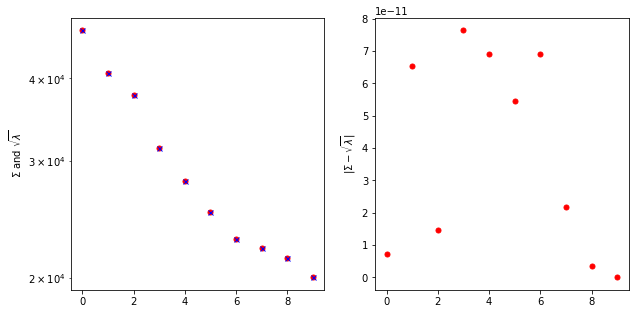

In [13]:
n_eigs_to_check = 10
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(np.real(eigs[:n_eigs_to_check]) ** 0.5, marker='o', c='r', linestyle='none', markersize=5)
ax.plot(Sigma[:n_eigs_to_check], marker='x', c='b', linestyle='none', markersize=5)
ax.set_yscale('log')
ax.set_ylabel('$\Sigma$ and $\sqrt{\lambda}$')

ax = fig.add_subplot(1, 2, 2)
ax.plot(np.abs(np.real(eigs[:n_eigs_to_check]) ** 0.5 - Sigma[:n_eigs_to_check]), marker='o', c='r', linestyle='none', markersize=5)
ax.set_ylabel('$|\Sigma - \sqrt{\lambda}|$')

# Exercise 6 
Now take your data matrix $\mathbf X'$ and randomly shuffle each of the data points (i.e. each *row*). Plot some examples to verify you have done this correctly.

Don't overwrite your original array! 

In [14]:
shuffled = []
X_three_shuffled = np.copy(X_three_shifted) # create a copy! 
for row in X_three_shuffled:
  np.random.shuffle(row)

In [15]:
X_three_shuffled.shape

(6131, 784)

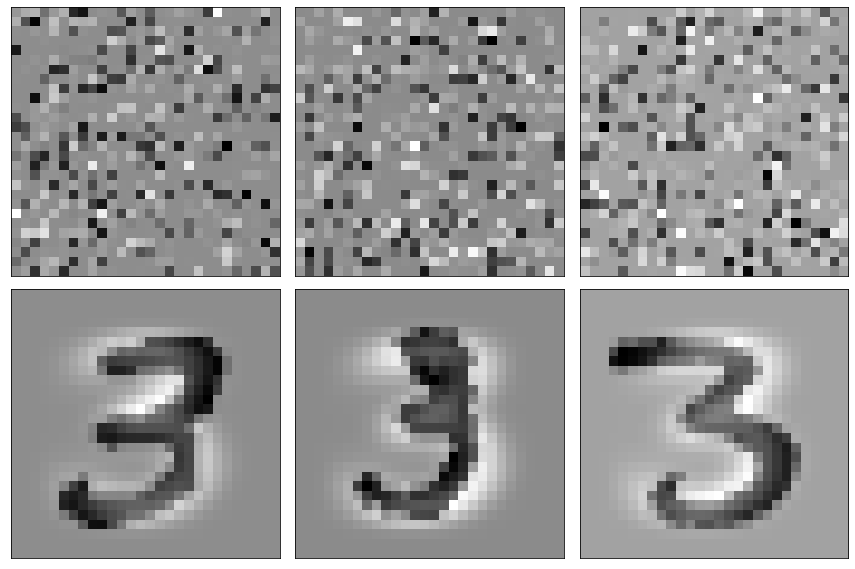

In [16]:
n_plot = 3

fig = plt.figure(figsize=(n_plot*4, 2*4))
for n in range(n_plot):
  ax = fig.add_subplot(2, n_plot, n+1)
  ax.imshow(X_three_shuffled[n,:].reshape((N_x, N_y)), cmap='gray_r')
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(2, n_plot, n_plot+n+1)
  ax.imshow(X_three_shifted[n,:].reshape((N_x, N_y)), cmap='gray_r')
  ax.set_xticks([])
  ax.set_yticks([])
fig.tight_layout()

# Exercise 7
Compare the singular values of the original data matrix of threes with the shuffled version. What do the results tell you, and why? 

In [17]:
U_shuffle, Sigma_shuffle, V_shuffle_T = la.svd(X_three_shuffled, full_matrices=True) 

(10, 100000)

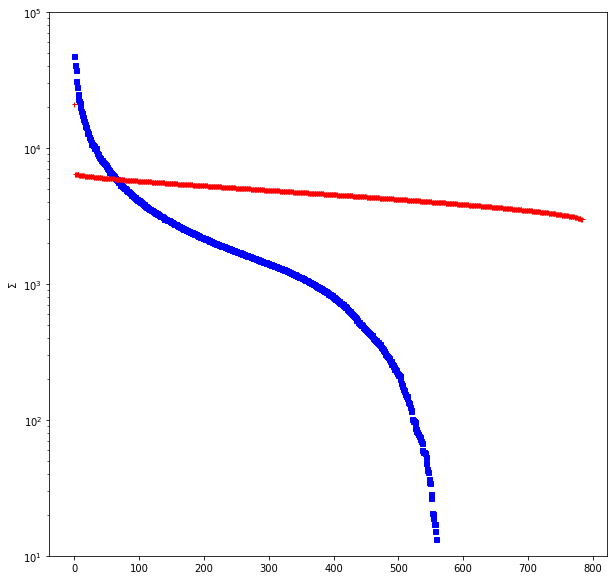

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(Sigma, marker='s', c='b', linestyle='none', markersize=5)
ax.plot(Sigma_shuffle, marker='+', c='r', linestyle='none', markersize=5)
ax.set_yscale('log')
ax.set_ylabel('$\Sigma$')

ax.set_ylim(10, 10**5)

# Exercise 8 
Make a low rank-$q$ tunrcation. What value of $q$ do you think is acceptable here? Note computing the projections might be quite intensive if you set $q$ to be large! 

Verify the reconstruction for a few images. You may want to refer to some of the equations derived/used in the lecture notes. 

(0.001, 1)

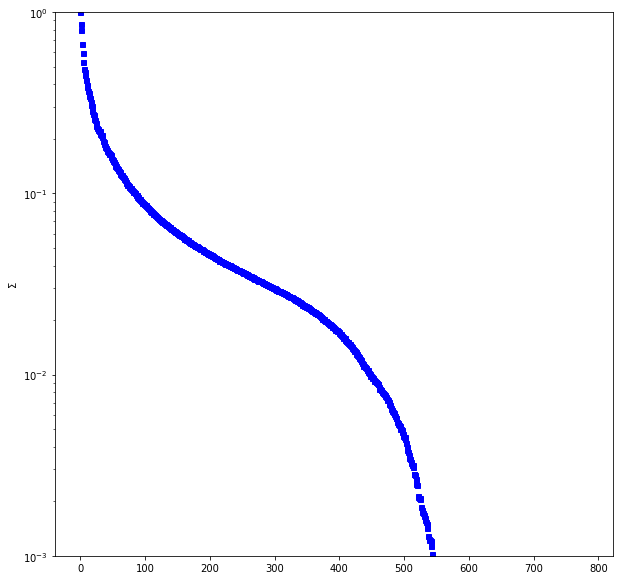

In [19]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(Sigma / Sigma[0], marker='s', c='b', linestyle='none', markersize=5)
ax.set_yscale('log')
ax.set_ylabel('$\Sigma$')
ax.set_ylim(1e-3, 1)

In [36]:
variance_thresholds = [0.33, 0.2, 0.1, 0.05, 0.01]
for thresh in variance_thresholds:
  Sigma_top = Sigma[Sigma/Sigma[0] > thresh]
  print("# modes for threshold energy " + str(thresh) + ' ' + str(Sigma_top.size))

# modes for threshold energy 0.33 16
# modes for threshold energy 0.2 35
# modes for threshold energy 0.1 86
# modes for threshold energy 0.05 184
# modes for threshold energy 0.01 448


~66% of the variance is contained in 16 modes 80% in 35 -- we'll select 35 as our truncation. The arguments for why depend very much on the problem at hand -- here we are interested in exploring PCA, so small numbers are good! 

In [38]:
X_three_mean.shape
X_three_shifted.shape

(6131, 784)

In [39]:
rank = 35
X_three_reconstruct = []

V = V_T.T

x_mean_flat = X_three_mean.reshape((-1,))

for x in X_three_shifted:
  x_shift = x - x_mean_flat
  x_r = x_mean_flat + V[:,:rank].dot(V_T[:rank,:]).dot(x_shift)
  X_three_reconstruct.append(x_r)

In [40]:
X_three_reconstruct = np.asarray(X_three_reconstruct)
X_three_reconstruct.shape

(6131, 784)

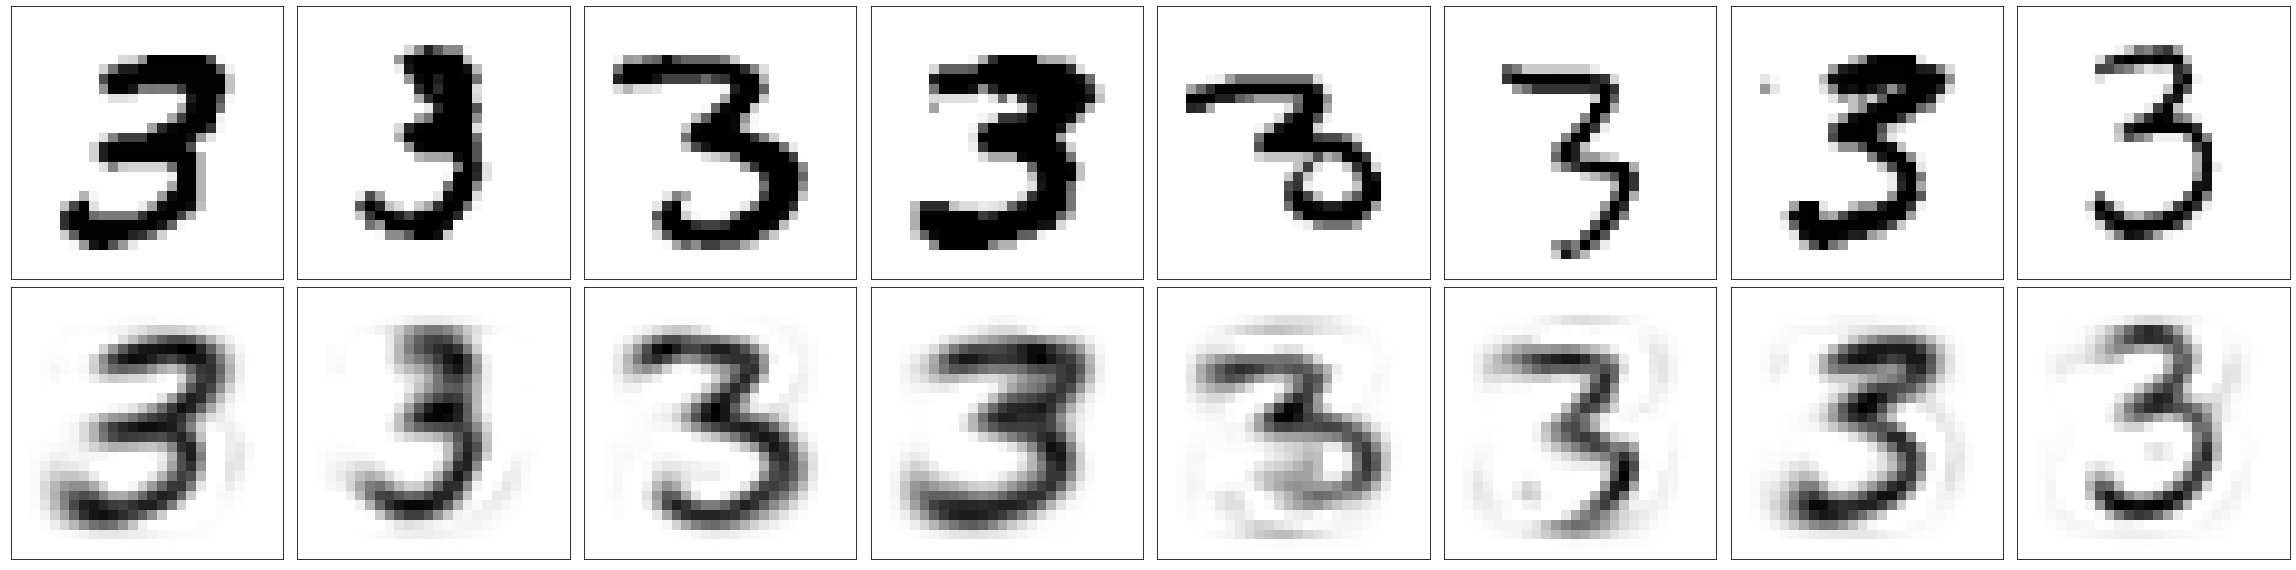

In [41]:
n_images = 8

# plot full image above, low-rank below

fig = plt.figure(figsize=(4*n_images, 4*2))
for j in range(n_images):
  ax = fig.add_subplot(2, n_images, j+1)
  ax.imshow(X_threes[j,:].reshape((N_x, N_y)), cmap='gray_r')
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(2, n_images, j+1+n_images)
  ax.imshow((X_three_reconstruct[j,:] + X_three_mean.reshape((-1,))).reshape((N_x, N_y)), cmap='gray_r', vmin=0.)
  ax.set_xticks([])
  ax.set_yticks([])
fig.tight_layout()

# Exercise 9 
Now consider the low-rank orthogonal vectors (columns of $\mathbf V_q$) you used to reconstruct the 3s in exercise 8. 

Let's try and use this as a basis for the other numbers. Try and reconstruct some of the other digits and compare the error. (Remember, in the notes, we derived the vectors $\boldsymbol \mu$ and $\mathbf w_j$ without specifying the basis vectors in $\mathbf V_q$. These solutions are the optimal choice for any given set of $q$ orthogonal vectors. We found the optimal basis for the data afterwards!)



---



How are you going to measure "error" here? You might want to discuss with the tutors

In [42]:
# here I'm going to over-engineer a little just for ease below
class data_matrix:
  def __init__(self, label, data):
    """ Data is design matrix X (N x D); label an integer class label. """ 
    self.label = label
    self.data = data
    self.mean = np.mean(self.data, axis=0, keepdims=True)
    self.data_shifted = self.data - self.mean

  def project_onto_basis(self, Vq):
    """ Project onto arbitrary orthogonal basis (cols of Vq) """ 
    rank = Vq.shape[1]
    projected_data = []
    for x in self.data_shifted:
      x_r = self.mean.flatten() + Vq.dot(Vq.T).dot(x)
      projected_data.append(x_r)
    return np.asarray(projected_data)

In [43]:
digits_to_test = range(10) #[1, 5, 8] # arbitrary but presumably 8 will be done quite well

data_matrices_to_test = {} # will create a dictionary of data natrices 
for digit in digits_to_test:
  N_digit = len(digits_dict[digit])
  X_ = np.asarray(digits_dict[digit]).reshape((N_digit, -1))
  data_matrices_to_test[digit] = data_matrix(digit, X_)

In [44]:
reconstructed_arrays = {}

for digit in digits_to_test:
  proj_mat = data_matrices_to_test[digit].project_onto_basis(V[:,:rank])
  reconstructed_arrays[digit] = proj_mat

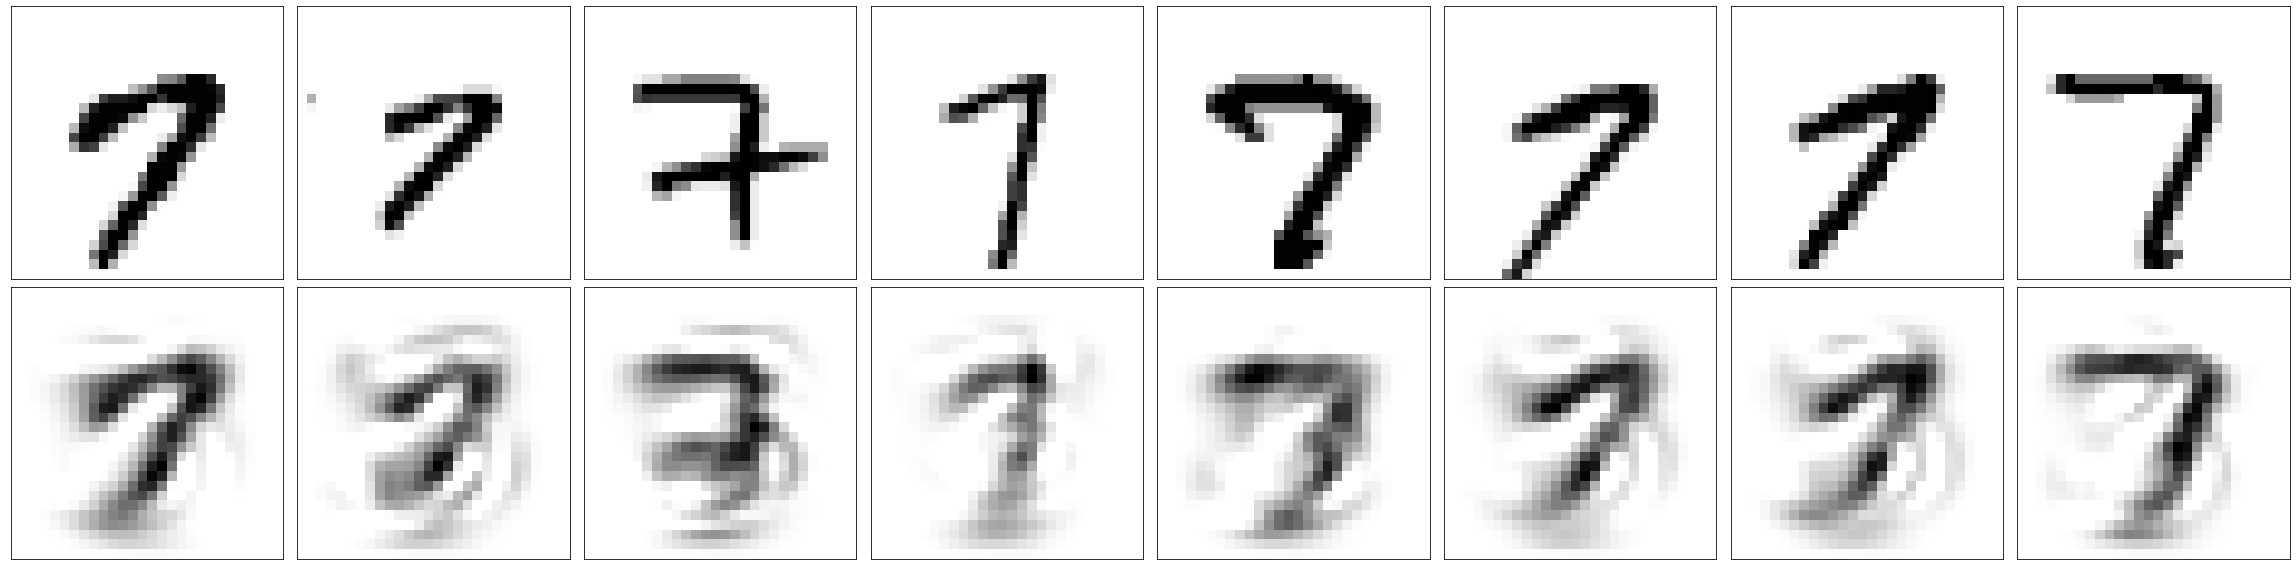

In [49]:
# plot some pictures for a given digit
n_images = 8

digit_plot = 7

fig = plt.figure(figsize=(4*n_images, 4*2))
for j in range(n_images):
  ax = fig.add_subplot(2, n_images, j+1)
  ax.imshow(data_matrices_to_test[digit_plot].data[j,:].reshape((N_x, N_y)), cmap='gray_r')
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(2, n_images, j+1+n_images)
  ax.imshow(reconstructed_arrays[digit_plot][j,:].reshape((N_x, N_y)), cmap='gray_r', vmin=0.)
  ax.set_xticks([])
  ax.set_yticks([])
fig.tight_layout()

In [50]:
# now compute the error over the data 
errors = {}
for digit in digits_to_test:
  errors[digit] = ((data_matrices_to_test[digit].data - reconstructed_arrays[digit])**2).mean(axis=None)

print(errors)

{0: 1646.776398543974, 1: 979.2430248212276, 2: 1703.9497330690533, 3: 803.6971316975266, 4: 1660.7773764135393, 5: 1342.166436185036, 6: 1675.0329454256223, 7: 1574.4603138495056, 8: 1528.1453510688025, 9: 1490.8050227484762}


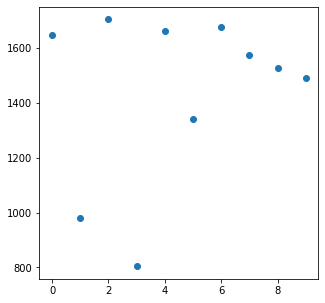

In [53]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.plot([val for val in errors], [errors[val] for val in errors], 'o')

# Exercise 10

Can you offer a simple explanation for why the reconstruction of some classes is noticably better than others?  

3, 1 and 5 are clearly better represented than the others. 3 is obvious!
For the 5 -- the similarity with 3 should be clear (the lower curl). 

For the 1 -- how accurately is the data represented by the mean 1? Possibly very well (a vertical straight line presumably has smaller variance over the inputs). Let's verify by computing the error when the reconstruction is based on the mean only:

In [55]:
error_one_mean_only = ((data_matrices_to_test[1].data - data_matrices_to_test[1].mean)**2).mean(axis=None)
error_one_mean_only

1864.1290476159575

Which explains the apparenty anomaly. 

# Exercise 11
Plot the first two principle components of your 3 dataset (you might want to select only a small number of points to plot). Can you attach any significance to these directions in terms of what they mean for the underlying image? (e.g. what is the effect of increasing the weighting of one of these PCs with the other held fixed?) 

NB this can be challenging (there might not be a clear answer!) but can give useful insights.

In [60]:
# we can do this with our original SVD of the threes 
principal_comps_threes = U[:,:Sigma.size].dot(np.diag(Sigma))

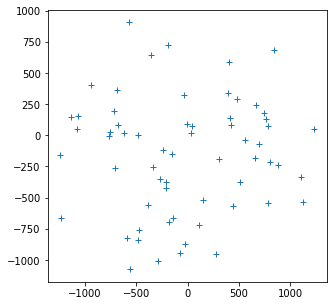

In [66]:
pc_i1 = 0
pc_i2 = 1 # indices to plot

coarse_factor = 100
principal_comps_coarse = principal_comps_threes[::coarse_factor]

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1) 
ax.plot(principal_comps_coarse[:, pc_i1], principal_comps_coarse[:, pc_i2], '+')

In [109]:
# strategy: (1) pick a random image 
# (2) artificially weight the first or second principal component [0.1 0.5 1. 2. 4.]
images_pc1 = []
images_pc2 = []
indx = int(np.random.rand() * N_threes)

weighting = [0., 1., 2., 4., 10.]

for w in weighting:
  U_mod = np.copy(U)
  U_mod[:,pc_i1] = w * U[:,pc_i1]
  images_pc1.append(X_three_mean + U_mod[indx, :Sigma.size].dot(np.diag(Sigma)).dot(V_T))

  U_mod = np.copy(U)
  U_mod[:,pc_i2] = w * U[:,pc_i2]
  images_pc2.append(X_three_mean + U_mod[indx, :Sigma.size].dot(np.diag(Sigma)).dot(V_T))

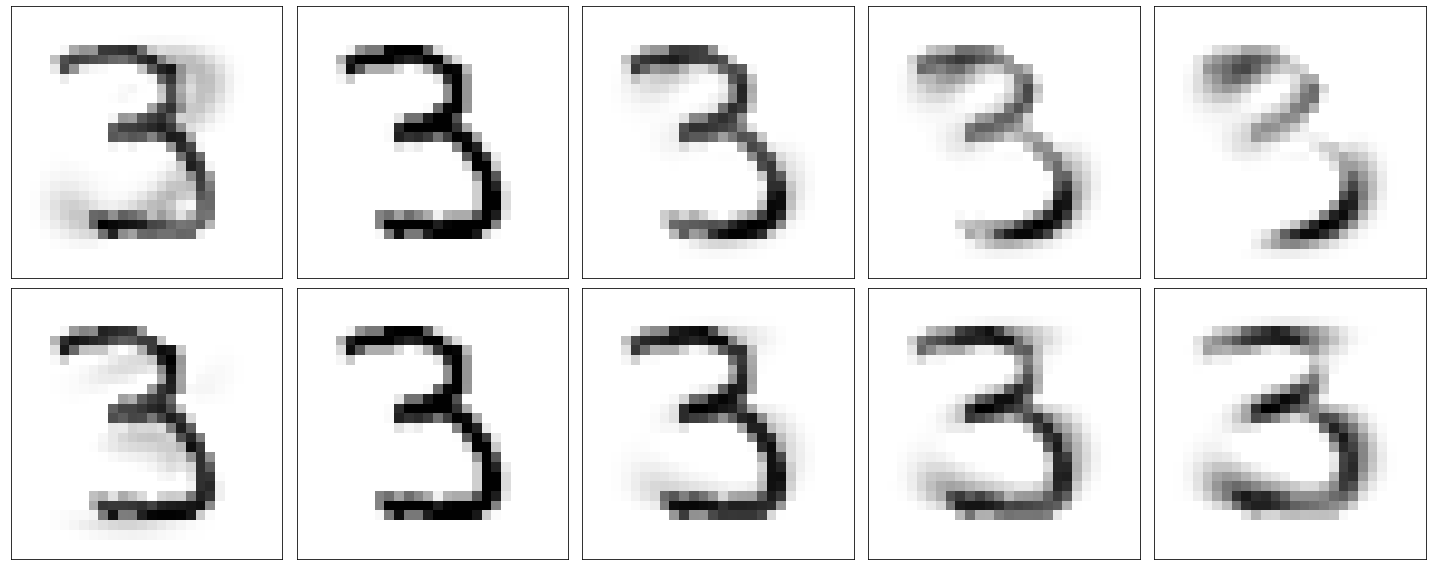

In [110]:
fig = plt.figure(figsize=(4*len(weighting), 4*2))
for j in range(len(weighting)):
  ax = fig.add_subplot(2, len(weighting), j+1)
  ax.imshow(images_pc1[j].reshape((N_x, N_y)), cmap='gray_r', vmin=0.)
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(2, len(weighting), j+1+len(weighting))
  ax.imshow(images_pc2[j].reshape((N_x, N_y)), cmap='gray_r', vmin=0.)
  ax.set_xticks([])
  ax.set_yticks([])
fig.tight_layout()

We can see that PC2 is assocated with a "thickening" of the character. 

# Exercise 12
Finally, consider now all of your images (for all digits). Compute the principle components for this dataset and plot the projection of the data onto the first few. If you plot (e.g.) PC1 vs PC2 (or others) do clusters emerge? 


---
This task is a little more open-ended and is something you can play around with to build intuition. Do not feel you have to finish it in the workshop or for the submission, I'm happy to discuss in the office hour etc. 
